# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bcda6ff9-4dde-8984-da05-5a33f072e025)


## Get the data

In [2]:
# Download bitcoin history data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-12-30 09:36:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2022-12-30 09:36:26 (40.2 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series with pandas

In [3]:
import pandas as pd

# Read it as a dataframe and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
len(df)

2787

In [6]:
# We only want closing prices for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


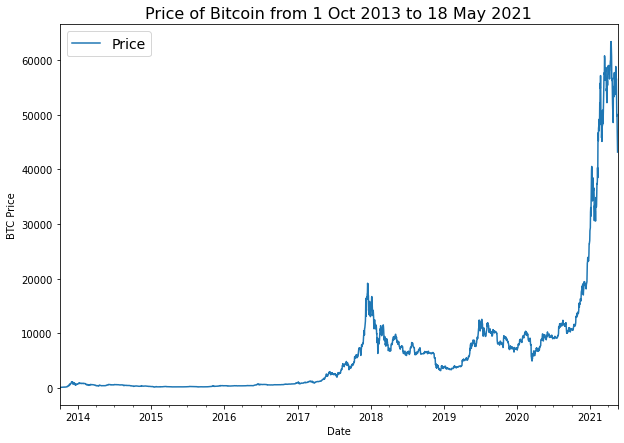

In [7]:
# Let's plot the data for each day
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [8]:
# Importing and formatting historical Bitcoin data
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) #Skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

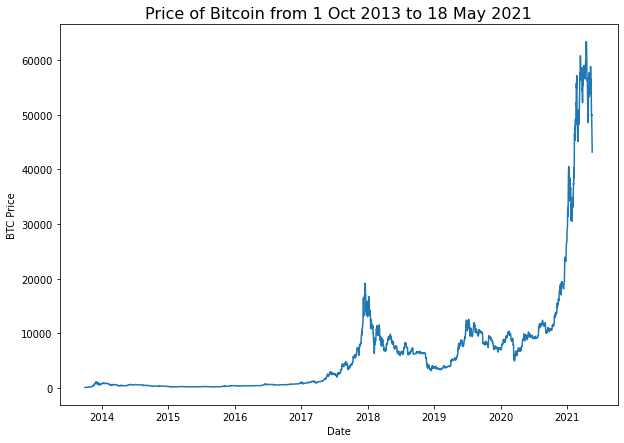

In [9]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format Data Part 1: Creating train and test sets for time series data


### Create train & test sets for time series (the wrong way)

In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

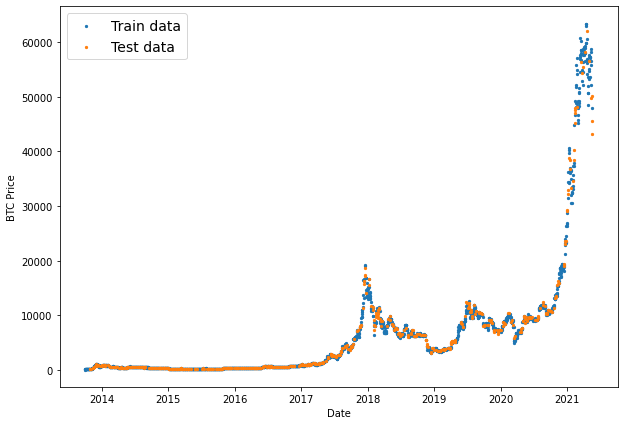

In [12]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

In [13]:
# Create train and test splits the right way for time series
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits 
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

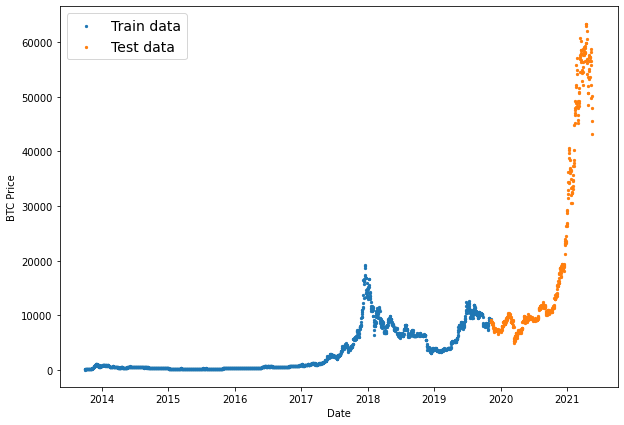

In [14]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

In [15]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

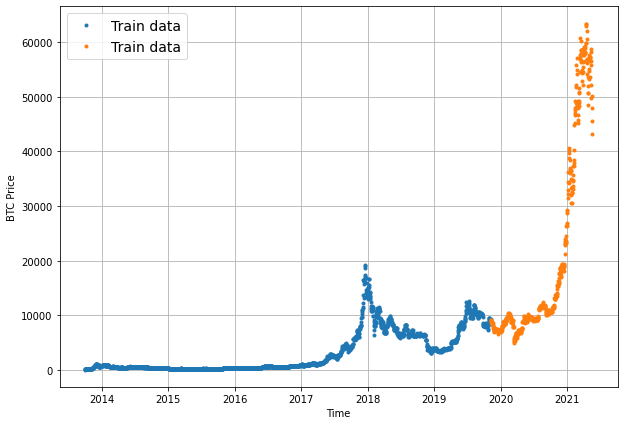

In [16]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Train data")

## Modelling Experiments


We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

> 🔑 **Note:** To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed. 

## Model 0: Naive Bayes Forecast

In [17]:
# Create a naive forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value 

# View first and last 10
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

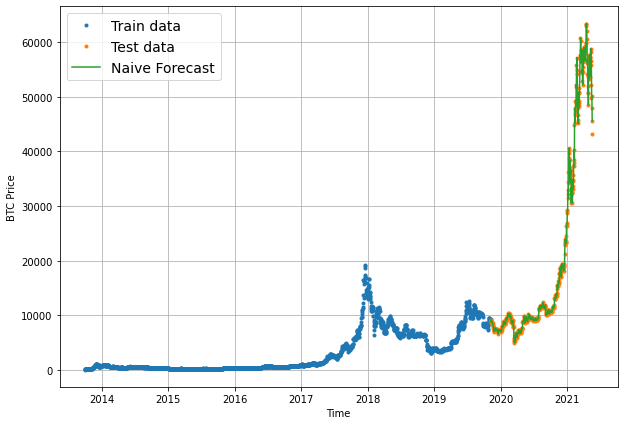

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

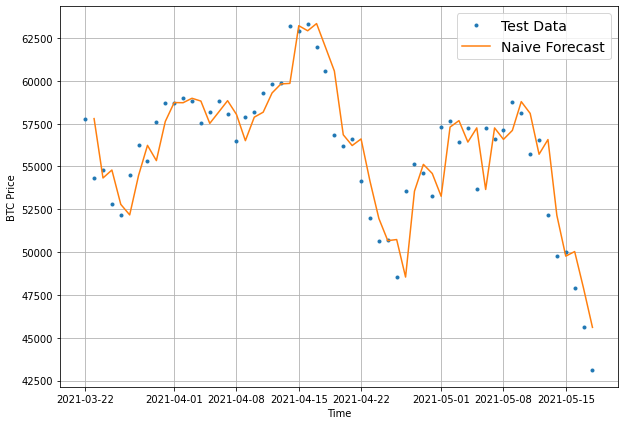

In [19]:
plt.figure(figsize=(10,7))
offset = 500
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive Forecast")

Now we can clearly see a regular gap (which is equal to 1) as naive method just predicts the next timestep value as the value at previous timestep

## Evaluating a time series model

In [20]:
# Let's get TensorFlow
import tensorflow as tf

In [21]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [22]:
# Lets make a function to evaluate all evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure y_true and y_preds both are of float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [24]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

## Format Data Part 2: Windowing dataset


```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [26]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Windows: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Windows: [1 2 3 4 5 6 7] -> Label: 8


In [28]:
# Create function to view numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T # Create 2D
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time_series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # Get the labelled window
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
len(prices)

2787

In [31]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [32]:
# View the last 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning Windows into training and  test sets

In [33]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [34]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [35]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [36]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

```We want to save the best performing model (according to epochs). So, lets create a model checkpoint to save that model```

In [37]:
import os

# Create a function to implement a model checkpoint callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed 
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile the model
model_1.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae"])

# Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 4s 90ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6528 - val_mae: 2279.6528
Epoch 2/100
18/18 [==============================] - 1s 46ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9993 - val_mae: 1005.9993
Epoch 3/100
18/18 [==============================] - 1s 48ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2861
Epoch 4/100
18/18 [==============================] - 1s 51ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 1s 58ms/step - loss: 165.0894 - mae: 165.0894 - val_loss: 895.2237 - val_mae: 895.2237
Epoch 6/100
18/18 [==============================] - 1s 45ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1984 - val_mae: 855.1984
Epoch 7/100
18/18 [==============================] - 1s 43ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9166 - val_mae: 840.9166
Epoch 8/100
18/1

In [39]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758


[585.9757690429688, 585.9757690429688]

In [40]:
# Load in saved best performing model 1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510


[568.9510498046875, 568.9510498046875]

## Making forecasts with a model (on the test dataset)

In [41]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """

  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return predictions as 1D Array 

In [42]:
# Make predictions using model 1
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [43]:
# Evaluate the performance of our model
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)

model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [44]:
# Did it beat the naive forecast
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Lets plot the prediction by model 1 against the original labels

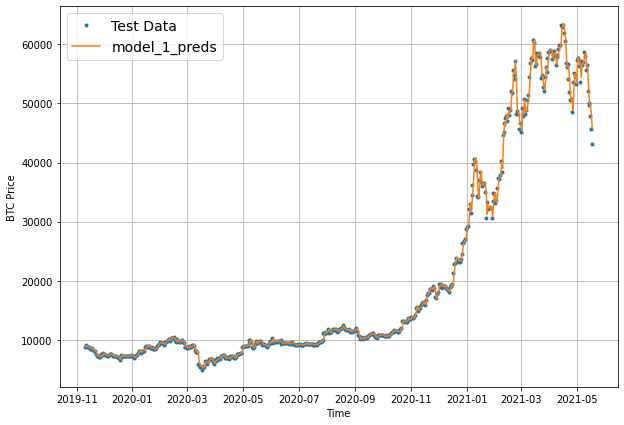

In [45]:
offset = 300
plt.figure(figsize=(10,7))

# Account for test window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [46]:
HORIZON = 1
WINDOW_SIZE=30

In [47]:
# Make windowed data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [48]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [49]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [50]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 659.3332 - mae: 659.3332


[659.3331909179688, 659.3331909179688]

In [51]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 605.8741 - mae: 605.8741


[605.8740844726562, 605.8740844726562]

In [52]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [53]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

Still not able to beat the naive model

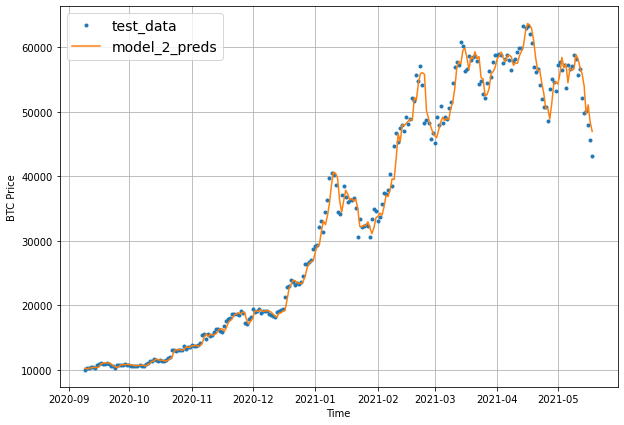

In [54]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon=7)

In [55]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [56]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [57]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [58]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1525 - mae: 1300.1525


[1300.1524658203125, 1300.1524658203125]

In [59]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1237.5065 - mae: 1237.5065


[1237.5064697265625, 1237.5064697265625]

In [60]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.891 , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [61]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 513.6056  ,  355.08328 ,  327.17075 ,  358.5106  ,  420.53305 ,
         537.854   ,  545.6617  ,  485.9228  ,  584.49713 ,  687.38214 ,
         836.2264  ,  755.1577  ,  731.4957  ,  775.3399  ,  567.95544 ,
         266.80865 ,  188.80217 ,  188.10799 ,  253.095   ,  301.43256 ,
         151.10721 ,  196.81473 ,  191.46178 ,  231.65031 ,  143.61125 ,
         122.59089 ,  132.78879 ,  190.8118  ,  179.15994 ,  228.26018 ,
         314.44022 ,  379.09244 ,  278.32526 ,  295.3471  ,  299.3852  ,
         248.64983 ,  299.75662 ,  259.69434 ,  180.30531 ,  206.72922 ,
         374.62863 ,  144.85086 ,  142.33635 ,  131.11613 ,   93.9412  ,
          54.825542,   73.79548 ,  103.60128 ,  121.333916,  168.67278 ,
         183.90945 ,  152.25307 ,  186.57199 ,  146.91267 ,  240.42912 ,
         351.00662 ,  540.952   ,  549.1573  ,  521.2411  ,  526.8554  ,
         453.36237 ,  257.98102 ,  277.29486 ,  301.8247  ,  455.718   ,
         458.96017 ,  503.4438  ,  522.3119 

## Make our evaluation function work for larger horizons

In [62]:
# Lets make a function to evaluate all evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure y_true and y_preds both are of float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for larger number of horizons)
  if mae.ndim > 0: #If it is not a scalar then we are going to take mean of every evaluation metrics
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [63]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mse': 5405198.5,
 'rmse': 1425.7478,
 'mape': 5.5588784,
 'mase': 2.2020733}

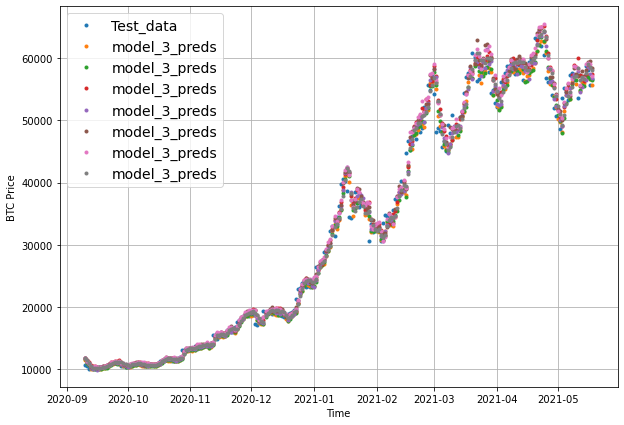

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

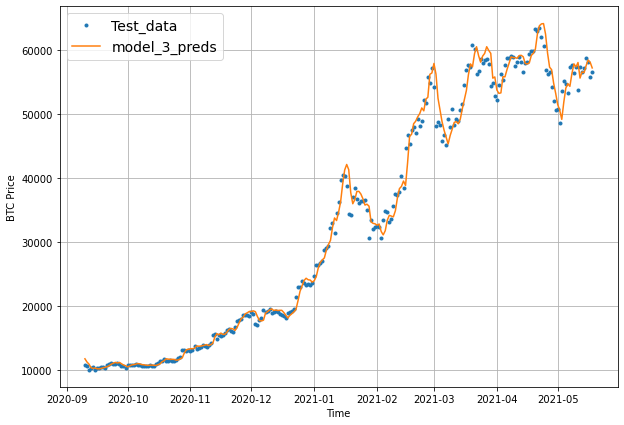

In [65]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-",start=offset, label="model_3_preds")

## Which of our model is performing best so far

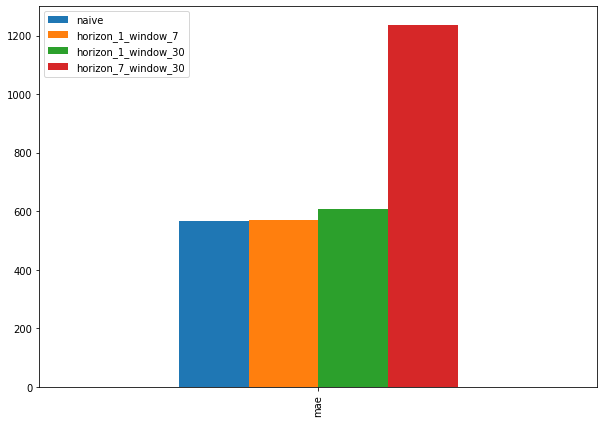

In [66]:
import pandas as pd
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index = ["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4: Conv1D

In [67]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [68]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [69]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [70]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [71]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shaoe: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shaoe: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [72]:
tf.random.set_seed(42)

# Create a model
model_4 = tf.keras.Sequential([
    # Create Lamba layer to reshape inputs
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1227.0372 - mae: 1227.0372  

18/18 [==============================] - 7s 70ms/step - loss: 1207.3817 - mae: 1207.3817 - val_loss: 2320.6218 - val_mae: 2320.6218
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 353.1946 - mae: 353.1946

18/18 [==============================] - 1s 38ms/step - loss: 316.2171 - mae: 316.2171 - val_loss: 1467.2799 - val_mae: 1467.2799
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 191.0237 - mae: 191.0237

18/18 [==============================] - 1s 37ms/step - loss: 192.6853 - mae: 192.6853 - val_loss: 1164.7074 - val_mae: 1164.7074
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 177.3535 - mae: 177.3535

18/18 [==============================] - 1s 38ms/step - loss: 177.3535 - mae: 177.3535 - val_loss: 981.6695 - val_mae: 981.6695
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 172.3467 - mae: 172.3467

18/18 [==============================] - 1s 37ms/step - loss: 172.3467 - mae: 172.3467 - val_loss: 960.8708 - val_mae: 960.8708
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 130.1246 - mae: 130.1246

18/18 [==============================] - 1s 37ms/step - loss: 171.9753 - mae: 171.9753 - val_loss: 950.2026 - val_mae: 950.2026
Epoch 7/100
14/18 [======================>.......] - ETA: 0s - loss: 173.6449 - mae: 173.6449

18/18 [==============================] - 1s 38ms/step - loss: 167.1943 - mae: 167.1943 - val_loss: 943.2872 - val_mae: 943.2872
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 163.5990 - mae: 163.5990

18/18 [==============================] - 1s 38ms/step - loss: 163.5990 - mae: 163.5990 - val_loss: 905.5262 - val_mae: 905.5262
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 162.5455 - mae: 162.5455 - val_loss: 929.7607 - val_mae: 929.7607
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 176.2612 - mae: 176.2612

18/18 [==============================] - 1s 37ms/step - loss: 158.5780 - mae: 158.5780 - val_loss: 871.9778 - val_mae: 871.9778
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 154.9709 - mae: 154.9709

18/18 [==============================] - 1s 38ms/step - loss: 154.0058 - mae: 154.0058 - val_loss: 852.7120 - val_mae: 852.7120
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 151.2620 - mae: 151.2620 - val_loss: 944.1970 - val_mae: 944.1970
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 150.2688 - mae: 150.2688 - val_loss: 881.1826 - val_mae: 881.1826
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 145.4593 - mae: 145.4593

18/18 [==============================] - 1s 37ms/step - loss: 145.4593 - mae: 145.4593 - val_loss: 849.1818 - val_mae: 849.1818
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 143.3098 - mae: 143.3098

18/18 [==============================] - 1s 54ms/step - loss: 143.3640 - mae: 143.3640 - val_loss: 844.4007 - val_mae: 844.4007
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 139.8764 - mae: 139.8764

18/18 [==============================] - 1s 39ms/step - loss: 139.8764 - mae: 139.8764 - val_loss: 806.7261 - val_mae: 806.7261
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 138.1677 - mae: 138.1677 - val_loss: 812.6340 - val_mae: 812.6340
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 147.8408 - mae: 147.8408

18/18 [==============================] - 1s 38ms/step - loss: 137.9497 - mae: 137.9497 - val_loss: 775.2100 - val_mae: 775.2100
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 79.5886 - mae: 79.5886

18/18 [==============================] - 1s 38ms/step - loss: 131.1450 - mae: 131.1450 - val_loss: 755.4260 - val_mae: 755.4260
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 133.8206 - mae: 133.8206

18/18 [==============================] - 1s 38ms/step - loss: 132.4057 - mae: 132.4057 - val_loss: 712.2014 - val_mae: 712.2014
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 131.0829 - mae: 131.0829

18/18 [==============================] - 1s 38ms/step - loss: 131.0829 - mae: 131.0829 - val_loss: 707.4122 - val_mae: 707.4122
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 126.9511 - mae: 126.9511

18/18 [==============================] - 1s 38ms/step - loss: 126.9511 - mae: 126.9511 - val_loss: 692.9736 - val_mae: 692.9736
Epoch 23/100
18/18 [==============================] - ETA: 0s - loss: 125.1489 - mae: 125.1489

18/18 [==============================] - 1s 37ms/step - loss: 125.1489 - mae: 125.1489 - val_loss: 682.4753 - val_mae: 682.4753
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 133.3014 - mae: 133.3014

18/18 [==============================] - 1s 37ms/step - loss: 124.3786 - mae: 124.3786 - val_loss: 670.8320 - val_mae: 670.8320
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 125.1436 - mae: 125.1436

18/18 [==============================] - 1s 36ms/step - loss: 121.6896 - mae: 121.6896 - val_loss: 662.6083 - val_mae: 662.6083
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 121.3545 - mae: 121.3545

18/18 [==============================] - 1s 37ms/step - loss: 121.5705 - mae: 121.5705 - val_loss: 654.6090 - val_mae: 654.6090
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 122.6445 - mae: 122.6445

18/18 [==============================] - 1s 38ms/step - loss: 122.6445 - mae: 122.6445 - val_loss: 650.9058 - val_mae: 650.9058
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 111.1428 - mae: 111.1428

18/18 [==============================] - 1s 51ms/step - loss: 117.9562 - mae: 117.9562 - val_loss: 645.4808 - val_mae: 645.4808
Epoch 29/100
18/18 [==============================] - ETA: 0s - loss: 117.1769 - mae: 117.1769

18/18 [==============================] - 1s 36ms/step - loss: 117.1769 - mae: 117.1769 - val_loss: 639.9748 - val_mae: 639.9748
Epoch 30/100
16/18 [=========================>....] - ETA: 0s - loss: 119.4724 - mae: 119.4724

18/18 [==============================] - 1s 37ms/step - loss: 121.0468 - mae: 121.0468 - val_loss: 630.7950 - val_mae: 630.7950
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9061 - mae: 114.9061 - val_loss: 652.6464 - val_mae: 652.6464
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 113.9315 - mae: 113.9315

18/18 [==============================] - 1s 38ms/step - loss: 116.4313 - mae: 116.4313 - val_loss: 623.4980 - val_mae: 623.4980
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7972 - mae: 115.7972 - val_loss: 664.3209 - val_mae: 664.3209
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 142.3728 - mae: 142.3728

18/18 [==============================] - 1s 37ms/step - loss: 117.2043 - mae: 117.2043 - val_loss: 613.7654 - val_mae: 613.7654
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4074 - mae: 113.4074 - val_loss: 619.6227 - val_mae: 619.6227
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 160.4943 - mae: 160.4943

18/18 [==============================] - 1s 36ms/step - loss: 116.8330 - mae: 116.8330 - val_loss: 605.7616 - val_mae: 605.7616
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 134.0515 - mae: 134.0515

18/18 [==============================] - 1s 36ms/step - loss: 114.7925 - mae: 114.7925 - val_loss: 603.6094 - val_mae: 603.6094
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 113.0861 - mae: 113.0861

18/18 [==============================] - 1s 37ms/step - loss: 113.0861 - mae: 113.0861 - val_loss: 602.5891 - val_mae: 602.5891
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 131.2348 - mae: 131.2348

18/18 [==============================] - 1s 38ms/step - loss: 111.9831 - mae: 111.9831 - val_loss: 602.2945 - val_mae: 602.2945
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 105.1074 - mae: 105.1074

18/18 [==============================] - 1s 37ms/step - loss: 111.2691 - mae: 111.2691 - val_loss: 600.5515 - val_mae: 600.5515
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0727 - mae: 112.0727 - val_loss: 623.0615 - val_mae: 623.0615
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7095 - mae: 116.7095 - val_loss: 645.0155 - val_mae: 645.0155
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 118.9676 - mae: 118.9676 - val_loss: 659.5667 - val_mae: 659.5667
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 125.4497 - mae: 125.4497 - val_loss: 678.8228 - val_mae: 678.8228
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 115.4361 - mae: 115.4361 - val_loss: 611.8370 - val_mae: 611.8370
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 114.1717 - mae: 114.1717

18/18 [==============================] - 1s 38ms/step - loss: 114.1717 - mae: 114.1717 - val_loss: 589.6738 - val_mae: 589.6738
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7248 - mae: 113.7248 - val_loss: 720.2481 - val_mae: 720.2481
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0136 - mae: 112.0136 - val_loss: 597.4332 - val_mae: 597.4332
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5680 - mae: 110.5680 - val_loss: 665.2030 - val_mae: 665.2030
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 119.7653 - mae: 119.7653 - val_loss: 635.1696 - val_mae: 635.1696
Epoch 51/100
18/18 [==============================] - ETA: 0s - loss: 110.7739 - mae: 110.7739

18/18 [==============================] - 1s 53ms/step - loss: 110.7739 - mae: 110.7739 - val_loss: 586.0245 - val_mae: 586.0245
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2179 - mae: 111.2179 - val_loss: 595.2483 - val_mae: 595.2483
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6466 - mae: 113.6466 - val_loss: 670.5778 - val_mae: 670.5778
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 126.7883 - mae: 126.7883 - val_loss: 648.2971 - val_mae: 648.2971
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6968 - mae: 110.6968 - val_loss: 593.8555 - val_mae: 593.8555
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8592 - mae: 109.8592 - val_loss: 766.5007 - val_mae: 766.5007
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 124.8183 - mae: 124.8183 - val_loss: 712.2674 - val_mae: 712.2674
Epoch 58/100
18/18 [============

18/18 [==============================] - 1s 39ms/step - loss: 108.1684 - mae: 108.1684 - val_loss: 577.6281 - val_mae: 577.6281
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7932 - mae: 108.7932 - val_loss: 610.1495 - val_mae: 610.1495
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4675 - mae: 110.4675 - val_loss: 652.9427 - val_mae: 652.9427
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7312 - mae: 110.7312 - val_loss: 583.0664 - val_mae: 583.0664
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3487 - mae: 108.3487 - val_loss: 587.8362 - val_mae: 587.8362
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 108.0646 - mae: 108.0646 - val_loss: 648.5150 - val_mae: 648.5150
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6957 - mae: 113.6957 - val_loss: 675.1595 - val_mae: 675.1595
Epoch 69/100
18/18 [============

18/18 [==============================] - 1s 38ms/step - loss: 106.6291 - mae: 106.6291 - val_loss: 575.4403 - val_mae: 575.4403
Epoch 82/100
16/18 [=========================>....] - ETA: 0s - loss: 112.8470 - mae: 112.8470

18/18 [==============================] - 1s 39ms/step - loss: 114.2934 - mae: 114.2934 - val_loss: 571.6199 - val_mae: 571.6199
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1759 - mae: 111.1759 - val_loss: 666.0590 - val_mae: 666.0590
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2543 - mae: 112.2543 - val_loss: 580.0314 - val_mae: 580.0314
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 107.7741 - mae: 107.7741 - val_loss: 599.6221 - val_mae: 599.6221
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7533 - mae: 108.7533 - val_loss: 599.0880 - val_mae: 599.0880
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9682 - mae: 106.9682 - val_loss: 596.5336 - val_mae: 596.5336
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9607 - mae: 107.9607 - val_loss: 598.1052 - val_mae: 598.1052
Epoch 89/100
17/18 [============

18/18 [==============================] - 1s 38ms/step - loss: 107.3045 - mae: 107.3045 - val_loss: 570.8284 - val_mae: 570.8284
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 108.0094 - mae: 108.0094 - val_loss: 642.3939 - val_mae: 642.3939
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7574 - mae: 113.7574 - val_loss: 625.3716 - val_mae: 625.3716
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0017 - mae: 108.0017 - val_loss: 627.3054 - val_mae: 627.3054
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 118.0999 - mae: 118.0999 - val_loss: 637.1274 - val_mae: 637.1274
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3195 - mae: 111.3195 - val_loss: 579.6985 - val_mae: 579.6985
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8561 - mae: 106.8561 - val_loss: 572.8486 - val_mae: 572.8486
Epoch 96/100
18/18 [============

In [73]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.8284 - mae: 570.8284


[570.828369140625, 570.828369140625]

In [75]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.464, 8754.47 , 8983.927, 8759.671, 8703.627, 8708.294,
       8661.667, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [76]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.82837,
 'mse': 1176671.2,
 'rmse': 1084.7448,
 'mape': 2.5593357,
 'mase': 1.0027874}

## Model 5: RNN (LSTM)

In [77]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae"])

# Fitting the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 6s 214ms/step - loss: 2922.5337 - mae: 2922.5337 - val_loss: 15656.8467 - val_mae: 15656.8467
Epoch 2/100
18/18 [==============================] - 3s 183ms/step - loss: 1443.4816 - mae: 1443.4816 - val_loss: 2677.9963 - val_mae: 2677.9963
Epoch 3/100
18/18 [==============================] - 3s 200ms/step - loss: 336.7440 - mae: 336.7440 - val_loss: 1000.9148 - val_mae: 1000.9148
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 205.3695 - mae: 205.3695 - val_loss: 1001.4442 - val_mae: 1001.4442
Epoch 5/100
18/18 [==============================] - 3s 181ms/step - loss: 179.5093 - mae: 179.5093 - val_loss: 984.5488 - val_mae: 984.5488
Epoch 6/100
18/18 [==============================] - 3s 181ms/step - loss: 180.6027 - mae: 180.6027 - val_loss: 974.4248 - val_mae: 974.4248
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 175.0692 - mae: 175.0692 - val_loss: 990.4905 - val_mae: 990.4905
E

In [78]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 588.9504 - mae: 588.9504


[588.9503784179688, 588.9503784179688]

In [79]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8878.773, 8709.733, 8973.68 , 8771.042, 8643.101, 8740.007,
       8685.089, 8458.451, 8440.228, 8489.815], dtype=float32)>

In [80]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 588.9504,
 'mse': 1229504.2,
 'rmse': 1108.8301,
 'mape': 2.662367,
 'mase': 1.0346227}

## Make a multivariate time series

In [81]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [82]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (this is out of the date range from our dataset)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [83]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days , block_reward_3_days

(1012, 2414)

In [84]:
# Add block reward column to our dataset
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


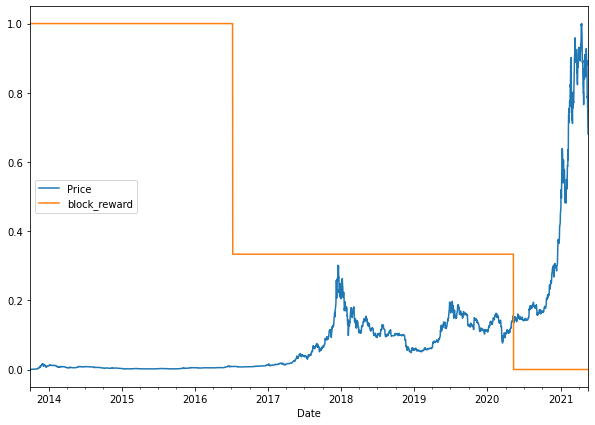

In [85]:
# Plot the block reward/price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

## Making a Windowed dataset with pandas

In [86]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [87]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [88]:
# Lets create X and y, remove the NaN's and convert to float32 (which tensorflow likes to see)
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [89]:
# View windows
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [90]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [91]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [92]:
tf.random.set_seed(42)

# Make multivariate time series model
# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 30ms/step - loss: 1234.6804 - val_loss: 2061.8840
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 351.5053 - val_loss: 1908.6816
Epoch 3/100
18/18 [==============================] - 0s 25ms/step - loss: 235.4153 - val_loss: 1329.0612
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 208.6112 - val_loss: 1102.1311
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 196.5770 - val_loss: 1107.8501
Epoch 6/100
18/18 [==============================] - 0s 24ms/step - loss: 187.2245 - val_loss: 1036.1696
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 182.0245 - val_loss: 1019.2947
Epoch 8/100
18/18 [==============================] - 0s 23ms/step - loss: 175.7059 - val_loss: 977.8505
Epoch 9/100
18/18 [==============================] - 0s 25ms/step - loss: 170.1784 - val_loss: 954.4052
Epoch 10/100
18/18 [==============================] - 0s 

In [93]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8910


567.8909912109375

In [94]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.684, 8769.905, 9045.17 , 8747.686, 8728.429, 8772.757,
       8667.292, 8503.437, 8470.313, 8527.244], dtype=float32)>

In [95]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.8909,
 'mse': 1164817.6,
 'rmse': 1079.2671,
 'mape': 2.5460868,
 'mase': 0.9976271}

In [96]:
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [97]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Model 7: N-BEATS algorithm

In [98]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each pf "relu" activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden:
      x = layer(x)
       
      theta = self.theta_layer(x)
      # Output the backcast and forecast from theta
      backcast, forecast = theta[:, self.input_size], theta[:, -self.horizon]

      return backcast, forecast

In [99]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [100]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [101]:
# Pass dummy inputs to NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: 1.1991426944732666
Forecast: 1.1991426944732666


### Preparing data for the N-Beats algorithm using ```tf.data```

In [102]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [103]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [104]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [105]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [106]:
# 1. Turn train and test arrays into tensor DataSets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine fetures and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [107]:
# Taking values from n beats paper figure 1 and table 18/appendix d
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residuals connections

In [108]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])


# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS agorithm

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [109]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 144: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 244: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 20 s, sys: 678 ms, total: 20.7 s
Wall time: 19.2 s


In [110]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 13ms/step - loss: 577.4228 - mae: 577.4228 - mse: 1172263.5000


[577.4227905273438, 577.4227905273438, 1172263.5]

In [111]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 635ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8838.898, 8781.042, 9041.417, 8743.463, 8798.7  , 8767.94 ,
       8633.603, 8515.877, 8528.15 , 8510.553], dtype=float32)>

In [112]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 577.4228,
 'mse': 1172263.5,
 'rmse': 1082.7112,
 'mape': 2.6045964,
 'mase': 1.0143719}

### Plotting the NBeats Architecture

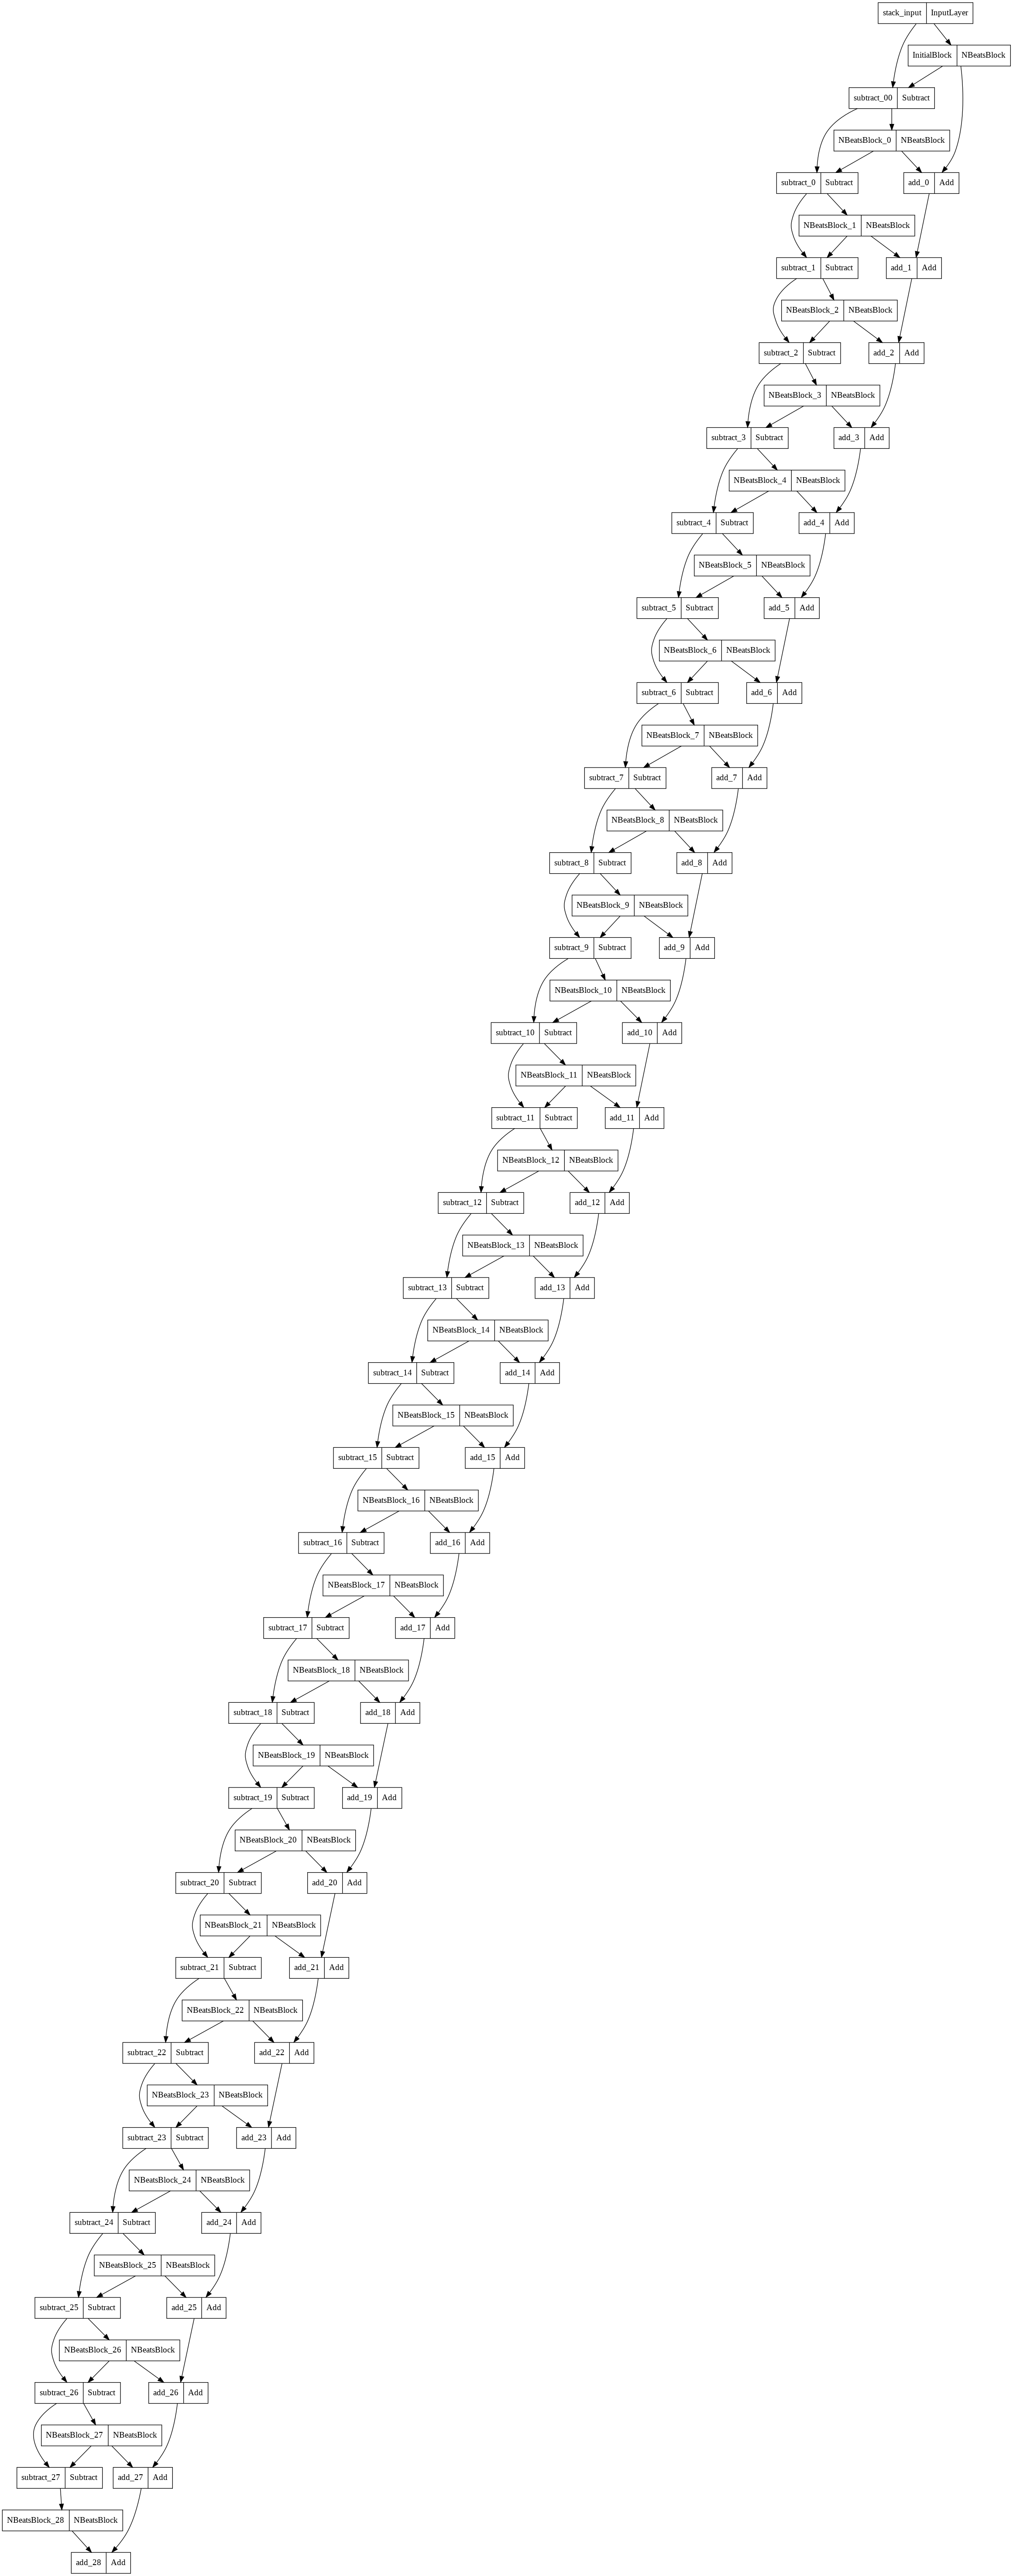

In [113]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

## Constructing  and fitting an ensemble of models (using different loss functions)

In [114]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss_function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model
      model = tf.keras.Sequential([
          # Initialize layers with normal distribution
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

    # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models   

In [115]:
%%time

# Get list of trained ensemble models
ensemble_model = get_ensemble_models(num_iter=5,
                                    num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 552: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 753: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 853: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 612: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 712: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 167: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 690: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 790: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 805: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 973:

In [116]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [117]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_model,
                                     data=test_dataset)

ensemble_preds

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8789.176 ,  8813.847 ,  9104.162 , ..., 49850.344 , 48835.15  ,
        46454.926 ],
       [ 8787.448 ,  8800.351 ,  9060.503 , ..., 49907.71  , 48163.117 ,
        46568.754 ],
       [ 8789.944 ,  8845.974 ,  9082.619 , ..., 49744.445 , 48477.594 ,
        45883.29  ],
       ...,
       [ 8770.8955,  8792.078 ,  9128.709 , ..., 50269.195 , 48487.89  ,
        46746.21  ],
       [ 8719.807 ,  8726.375 ,  9022.421 , ..., 50147.633 , 48135.46  ,
        46032.617 ],
       [ 8808.545 ,  8835.306 ,  9058.426 , ..., 49955.086 , 48809.637 ,
        45949.684 ]], dtype=float32)>

In [118]:
# Evaluating ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))

ensemble_results

{'mae': 569.0799,
 'mse': 1156726.6,
 'rmse': 1075.5122,
 'mape': 2.5537581,
 'mase': 0.99971575}

In [119]:
# Evaluating ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.mean(ensemble_preds, axis=0))

ensemble_results

{'mae': 567.1606,
 'mse': 1151240.1,
 'rmse': 1072.9586,
 'mape': 2.5526245,
 'mase': 0.99634403}

### Plotting the prediction intervals (uncertainity estimates) of our ensemble


One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method: 
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [120]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of our predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96 (as it covers 95% confidence)
  interval = 1.96 * std

  # 4. Get the prediction intervals upper and lower bound
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

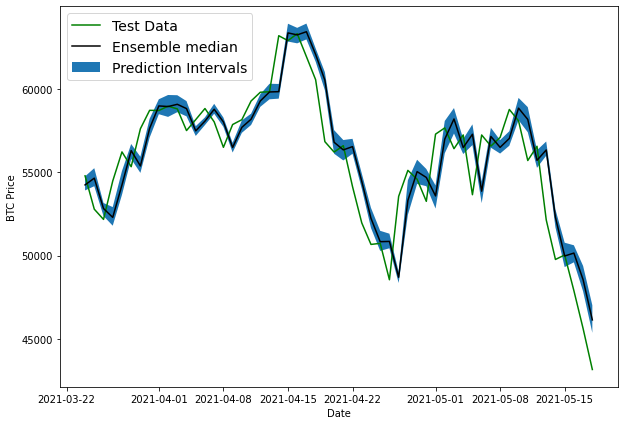

In [121]:
# Get the median value of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# Use fill_between() method to plot intervals
plt.fill_between(X_test.index[offset:],
                 lower[offset:],
                 upper[offset:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

## Model 9: Train a model on the full historical data to make predictions into the future

In [123]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [124]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [125]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [126]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile the model
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions on the future

In [128]:
# Timesteps to predict into the future?
INTO_FUTURE = 14 # We will predict into 2 weeks

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction 
  * Eventually future predictions will be made using the model's own previous predictions as input 

In [132]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size = WINDOW_SIZE):
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """

  # 2. Make an empty list for future forecasts / prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted each time
  for _ in range(into_future):

    # Predict on last window then append it again, again and again
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on : \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with the new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [133]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 50ms/step
Predicting on : 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.47265625

1/1 [==============================] - 0s 16ms/step
Predicting on : 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.47265625] -> Prediction: 50985.9296875

1/1 [==============================] - 0s 15ms/step
Predicting on : 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.47265625 50985.9296875 ] -> Prediction: 48522.9609375

1/1 [==============================] - 0s 18ms/step
Predicting on : 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.47265625 50985.9296875  48522.9609375 ] -> Prediction: 48137.19921875

1/1 [==============================] - 0s 17ms/step
Predicting on : 
 [47885.62525472 45604.61575361 43144.47129086 55764.47265625
 50985.9296875  48522.9609375  4813

In [134]:
future_forecast

[55764.473,
 50985.93,
 48522.96,
 48137.2,
 47880.633,
 46879.715,
 48227.594,
 53963.684,
 49685.543,
 47596.176,
 48114.418,
 48807.996,
 48623.85,
 50178.715]

### Plot future forecasts

In [135]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """

  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D")

  return np.arange(start_date, end_date, dtype="datetime64[D]") # return dates ranging between start date and end date

In [136]:
# Last timestep of timesteps
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [137]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)

next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

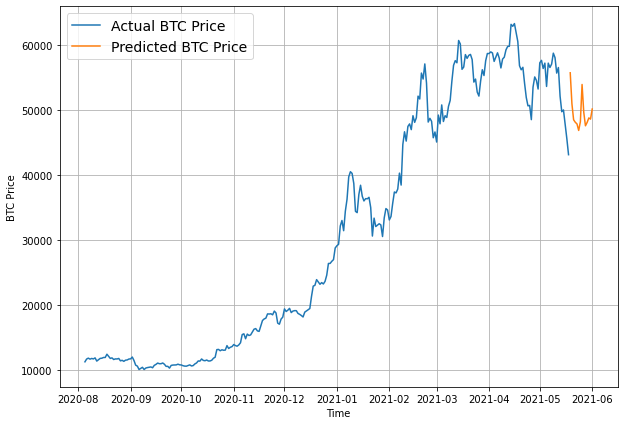

In [138]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

The graph looks like it is having a break so to remove this kind of break we must insert the last date of original dataset to the next_time_steps

Let's do it

In [139]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.473, 50985.93 , 48522.96 , 48137.2  , 47880.633,
        46879.715, 48227.594, 53963.684, 49685.543, 47596.176, 48114.418,
        48807.996, 48623.85 , 50178.715], dtype=float32))

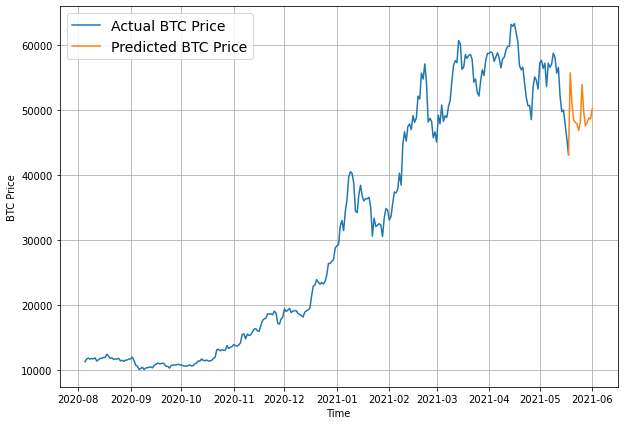

In [141]:
# Let's nos try plotting the future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [142]:
# Let's introduce a Turkey problem to our BTC data
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [143]:
# Manufacture an extra price on the end
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [144]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

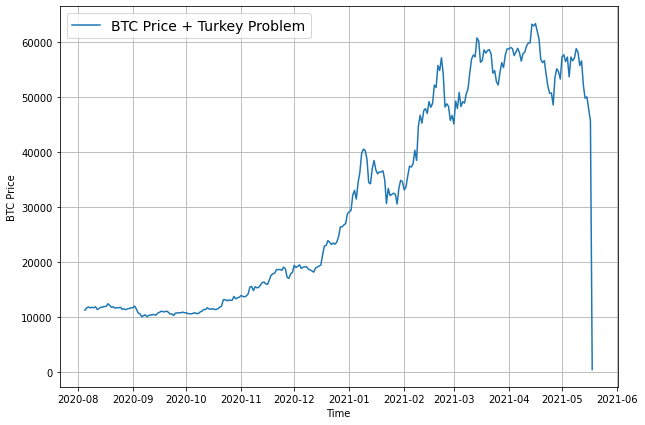

In [145]:
# Plotting the turkey dataset
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [146]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

In [147]:
# Clone model 1 architecture for turkey model and fit the turkey model
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"

# Compile the model
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())

# Fitting the model
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=1,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

Epoch 1/100
70/70 [==============================] - 2s 14ms/step - loss: 384.1429 - val_loss: 1122.0878
Epoch 2/100
70/70 [==============================] - 1s 11ms/step - loss: 178.2676 - val_loss: 1038.7152
Epoch 3/100
70/70 [==============================] - 1s 8ms/step - loss: 168.7874 - val_loss: 921.9125
Epoch 4/100
70/70 [==============================] - 1s 9ms/step - loss: 154.9035 - val_loss: 888.4297
Epoch 5/100
70/70 [==============================] - 1s 8ms/step - loss: 150.8394 - val_loss: 859.4333
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 147.2258 - val_loss: 872.5936
Epoch 7/100
70/70 [==============================] - 1s 8ms/step - loss: 142.4140 - val_loss: 807.4330
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 140.8866 - val_loss: 831.4067
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 131.4214 - val_loss: 1071.2717
Epoch 10/100
70/70 [==============================] - 1s 8ms/step - 

In [148]:
# Evaluate turkey model
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 786.2139


786.2139282226562

In [149]:
# Load best model and then evaluate that
turkey_model = tf.keras.models.load_model("/content/model_experiments/Turkey_Model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 638.3048


638.3048095703125

In [150]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8858.391, 8803.98 , 9039.576, 8785.936, 8778.044, 8735.638,
       8684.117, 8558.66 , 8461.372, 8542.205], dtype=float32)>

In [151]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17144.766,
 'mse': 615487740.0,
 'rmse': 23743.303,
 'mape': 121.58286,
 'mase': 26.53158}

In [152]:
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

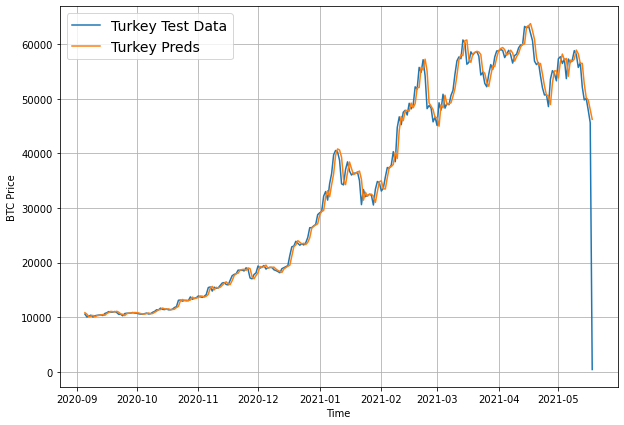

In [153]:
# Plotting the turkey model predictions
plt.figure(figsize=(10, 7))

offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data",
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 format="-",
                 label="Turkey Preds",
                 start=offset)

## Compare Models

In [154]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.951111,1.171744e+06,1082.471069,2.544898,0.999490
model_2_dense_w30_h1,605.874084,1.273361e+06,1128.432861,2.726445,1.059074
model_3_dense_w30_h7,1237.506348,5.405198e+06,1425.747803,5.558878,2.202073
model_4_CONV1D,570.828369,1.176671e+06,1084.744751,2.559336,1.002787
model_5_LSTM,588.950378,1.229504e+06,1108.830078,2.662367,1.034623
model_6_multivariate,567.890930,1.164818e+06,1079.267090,2.546087,0.997627
model_8_NBEATs,577.422791,1.172264e+06,1082.711182,2.604596,1.014372
model_9_ensemble,567.160583,1.151240e+06,1072.958618,2.552624,0.996344
model_10_turkey,17144.765625,6.154877e+08,23743.302734,121.582863,26.531580


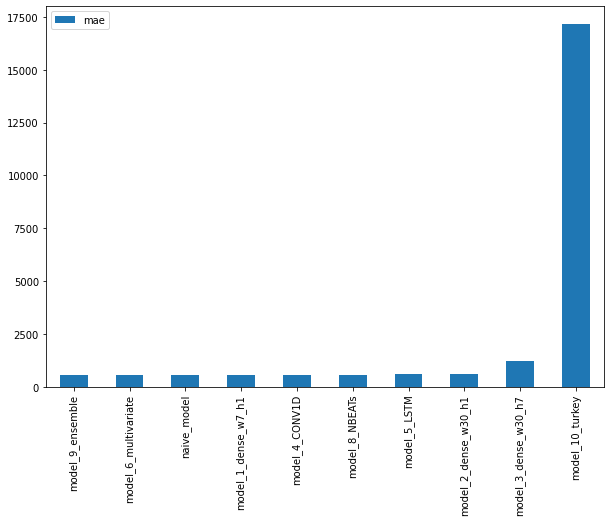

In [156]:
# Sort model results by mae and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")

## Thank You !!